In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [2]:
cfg = Config.fromfile("./_universe_config.py")

cfg.data.test.test_mode = True

In [3]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
epoch = 'epoch_28'

In [5]:
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

/opt/ml/detection/baseline/mmdetection/mmdet/models/dense_heads/anchor_head.py:118: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: ./work_dirs/_universe/epoch_28.pth


In [6]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 1.7 task/s, elapsed: 2820s, ETA:     0s

In [7]:
# convert output into submission file

prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])

submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,0 0.35374725 463.78915 591.29816 586.75574 674...,test/0000.jpg
1,0 0.2693287 129.13547 0.082458496 498.1565 259...,test/0001.jpg
2,0 0.52628076 85.31067 271.43265 440.3098 594.0...,test/0002.jpg
3,0 0.19921081 0.0 0.0 1024.0 297.18436 0 0.1848...,test/0003.jpg
4,0 0.7242603 446.22748 407.7176 653.5322 556.81...,test/0004.jpg
...,...,...
4866,0 0.3312615 288.97922 350.59155 667.80365 688....,test/4866.jpg
4867,0 0.49469656 629.8624 670.1169 776.1845 714.80...,test/4867.jpg
4868,0 0.20259234 469.50366 659.33234 539.50256 709...,test/4868.jpg
4869,0 0.751358 3.7851562 232.22665 1012.6671 915.4...,test/4869.jpg


389
0 General trash
405 431 760 635 0.62320226
1 Paper
2 Paper pack
3 Metal
4 Glass
5 Plastic
6 Styrofoam
7 Plastic bag
402 435 755 633 0.8441836
8 Battery
9 Clothing


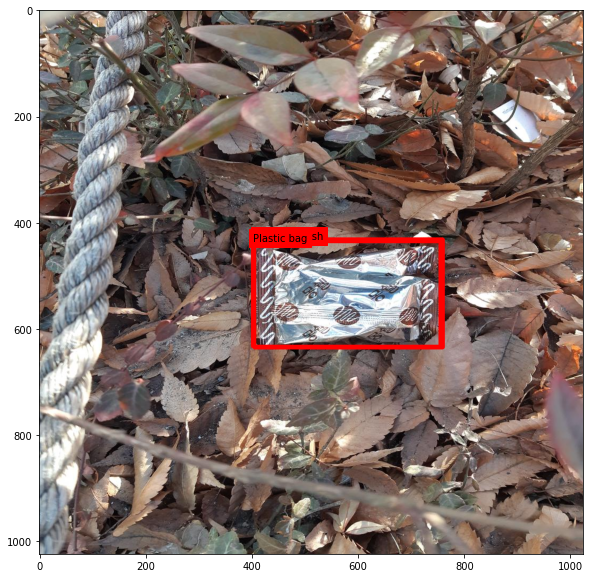

In [8]:
import matplotlib.pyplot as plt
import cv2

i = np.random.randint(0, 4871)
print(i)

root = '../../dataset/'
image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
img_name = os.path.join(root, image_info['file_name'])

img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

out = output[i]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for clss in range(class_num):
    print(clss, cfg.classes[clss])

    for out_per_clss in out[clss]:
        left, top, right, bottom, score = out_per_clss
        left, top, right, bottom = map(int, [left, top, right, bottom])
                
        if score>=0.5:
            print(left, top, right, bottom, score)
            img = cv2.rectangle(img, (left, top), (right, bottom), (255, 0, 0), 5)
            ax.text(x=left, y=top, s=cfg.classes[clss], backgroundcolor='red')

plt.imshow(img)

plt.show()